## LangGraph Basics

Topics covered:
- State 
- Nodes
- Edges
- Graphs
- Memory

Use custom LangGraph when:

- You need custom control flow (e.g., approval workflows)
- Building multi-agent systems
- Implementing human-in-the-loop patterns
- Complex state management requirements

In [ ]:
# Setup

import os
from dotenv import load_dotenv

load_dotenv()

True

---
## Simple mockup example

Let's try to understand the basics of how to build a LangGraph graph:

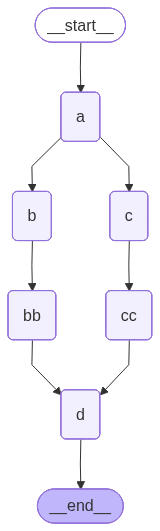

In [2]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, TypedDict
from langgraph.graph import END, START, StateGraph


# State

class State(TypedDict):
    nlist: Annotated[List[str], operator.add]
    

# Nodes

def node_a(state: State) -> State:
    print(f"Adding 'A' to {state['nlist']}")
    return(State(nlist = ["A"]))

def node_b(state: State) -> State:
    print(f"Adding 'B' to {state['nlist']}")
    return(State(nlist = ["B"]))

def node_c(state: State) -> State:
    print(f"Adding 'C' to {state['nlist']}")
    return(State(nlist = ["C"]))

def node_bb(state: State) -> State:
    print(f"Adding 'BB' to {state['nlist']}")
    return(State(nlist = ["BB"]))

def node_cc(state: State) -> State:
    print(f"Adding 'CC' to {state['nlist']}")
    return(State(nlist = ["CC"]))

def node_d(state: State) -> State:
    print(f"Adding 'D' to {state['nlist']}")
    return(State(nlist = ["D"]))


# Graph Builder

builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "bb")
builder.add_edge("c", "cc")
builder.add_edge("bb", "d")
builder.add_edge("cc", "d")
builder.add_edge("d",END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'BB' to ['Initial String:', 'A', 'B', 'C']
Adding 'CC' to ['Initial String:', 'A', 'B', 'C']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'BB', 'CC']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'CC', 'D']}

---
## A Real use Case Example now: a ReAct Agent

## State

The State defines the structure of the data that will be passed between nodes in the graph. It allows you to specify the types of data that each node will receive and produce. It can be represented in either of the following ways:

- Using `TypedDict` from the `typing_extensions` module.
- Using `Annotated` types from the `typing` module.
- Using Pydantic models.

In [4]:
# Building a ReAct Agent from scratch

from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps


class State(TypedDict):
    # Contains the full conversation history as it grows during the conversation
    messages: Annotated[List[AnyMessage], add_messages]

---
## Nodes

Nodes usually are LangChain Models, Tools or custom functions we can define. 

We could reuse tools from before, but we will use some new ones like Tavily to search the web.

In [5]:
from langchain_tavily import TavilySearch

# Initialize Tavily Search Tool
tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error

In [9]:
from langgraph.prebuilt import ToolNode
from langchain.chat_models import init_chat_model

# Node
tools = [tavily_search_tool]
tool_node = ToolNode(tools)

llm = init_chat_model("gpt-5-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langchain.messages import HumanMessage, AIMessage, SystemMessage


# This will be our node, the main assistant

def assistant(state: State):
    # Create a list of messages to send to the LLM, beginning with our fixed system prompt
    system_prompt = "You are a helpful assistant that can search the web using the Tavily tool when needed to give accurate and up-to-date information."
    all_messages = [SystemMessage(system_prompt)] + state["messages"]


	# Invoke the LLM
    response = llm_with_tools.invoke(all_messages)
    
    # Update the state with the response from the LLM
    return {"messages": [response]}

In [11]:
# Conditional edge that determines whether to continue or not
def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    # The LLM wants to make tool calls, we should execute them and continue
    if last_message.tool_calls:
        return "continue"
    # The LLM returned a response instead of tool calls, we're finished
    # Otherwise if there is, we continue
    else:
        return "end"

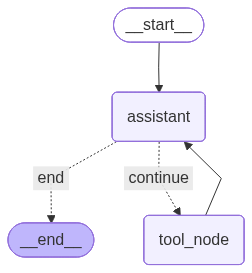

In [12]:
from langgraph.graph import StateGraph, START, END

# Start by defining a builder with our State class
builder = StateGraph(State)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tool_node", tool_node)


# Add edges
# First, we define the start node. The query will always route to the assistant node first.
builder.add_edge(START, "assistant")

# Add in the conditional edge after we call the LLM
builder.add_conditional_edges(
    "assistant",
    should_continue,
    {
        # If `continue`, then we call the tool node.
        "continue": "tool_node",
        # Otherwise we finish.
        "end": END,
    },
)

# Always return to the LLM after calling tools
builder.add_edge("tool_node", "assistant")

agent = builder.compile(name="agent")
agent

In [13]:
from langchain.messages import HumanMessage

question = "What is the latest released version of the LangChain Python library?"

result = agent.invoke({"messages": HumanMessage(content=question)})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the latest released version of the LangChain Python library?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_lywp6L1U92iZJv2FwBCxNaUG)
 Call ID: call_lywp6L1U92iZJv2FwBCxNaUG
  Args:
    query: LangChain Python latest released version PyPI langchain version latest
    search_depth: advanced
    include_images: False
================================= Tool Message =================================
Name: tavily_search

{"query": "LangChain Python latest released version PyPI langchain version latest", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://pypistats.org/packages/langchain", "title": "langchain - PyPI Download Stats", "content": "PyPI page\n  \nHome page\n  \nAuthor:\nNone\n  \nLicense:\nMIT\n  \nSummary:\nBuilding applications with LLMs through composability\n  \nLatest version:\n1.1.0\